In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import inv
from matplotlib import cm, rcParams
from mpl_toolkits.mplot3d import Axes3D 


%matplotlib inline

In [2]:
## Diffusion Coefficients:

T = -2 ## experimental temperature (deg C)

Ds = 9.1E-4*np.exp(-(7.2E3)/(T+273.15)) 
    ## from Rempel and Wettlaufer: average of measured diffusion parameters reported by Ramseier (1967) 
    ## solid state diffusion for ice (m^2/s)

Dl = 1.728E-8 - 1.575E-10*(T+273.15) + 3.591E-13*(T+273.15)**2  
    ## from Rempel and Wettlaufer: experimental data by Gillen and others (1972) 
    ## super cooled water diffusivity (m^2/s)


In [76]:
##  Constants

dt = 60.0                         ##  (s) time step- 60 seconds 
dz = 0.2/100.0                    ##  (m)
nz = 100
dx = 1.0E-6
nx = 1001

days = 21.0
time = days*24.0*60.0*60.0        ##  (s)  total time of experiment 
t = 21.0*24.0*60.0*60.0
m = 350.0/1000.0                  ##  (kg) total mass loss
r = 7.62/100.0                    ##  (m)  radius of tube
A = np.pi*r**2                    ##  (m^2)  cross-sectional area 

rho = 917.0                       ##  (kg/m^3)  ice density 
M = 18.01488/1000.0               ##  (kg/mol)  molar mass of H20

s = m/t                        ##  (kg/s) sublimation rate
sub = 10*(m/(t*A))*(1.0/M)*2.0    ##  (mols/m^2*s) sublimation flux of total hydrogen (H+D) 


R_std = 1.5575E-4                 ##  (ratio)  D/H standard
alpha = 1.12                      ##  (ratio)  fractionation factor: ice --> vapor 



deltaD_0 = -60.0                  ##  (0/00)  initial delta D in parts per thousand 
R_ice_0 = deltaD_0/1000.0*R_std + R_std          ## (ratio)  D/H of ice at t = 0
perD_0_ice = R_ice_0/(R_ice_0 + 1.0)             ## (percent)  ratio of D/(D+H) of ice at t = 0


c_tot = rho*(1.0/M)*2.0          ##  (mols/m^3)  mols of total hydrogen (D+H) in 1 m^3 of ice
mols_V = c_tot*dz*dx**2          ##  (mols)  mols of total hydrogen (D+H) in control volume 

h_new = dz - s*dt*(1.0/rho)*(1.0/A)         ##  (m) height of z = 0 disk after sublimation

c0 = c_tot*perD_0_ice
print Ds*dt/dx**2
print Dl*dt/dz**2

0.160370515982
0.0146361151463


In [77]:
## Surface Boundary Condition
c_0 = np.zeros(nx)
c_0 = c_0 + c0
c = np.zeros((nz, nx))
c = c + c0
cn = np.zeros((nz, nx))
c0n = np.zeros(nx)

## For sublimation flux loop
R_ice = np.zeros(nx)
R_vap = np.zeros(nx)
sub_flux = np.zeros(nx)


## For diffusive flux loop
F = np.zeros(nx)


surface = []

# nt = 1
nt = np.int(time/dt + 1.0)

for n in range(nt):
    surface_average = np.average(c[0, :])
    surface.append(surface_average)
    cn = c.copy()
    
    ## Sublimation Fulx
    R_vap = (cn[0, :]/c_tot)/(alpha*(1.0 - cn[0, :]/c_tot))
    sub_flux = sub*(R_vap/(R_vap + 1.0))
    c0n = cn[0, :]*dz/h_new - sub_flux*dt/h_new
    
    ## Diffusive Flux
    F = -Ds*(cn[1, :] - c0n)/h_new
  
    ## New Surface Condition
    c[0, 0] = (cn[0, 0]*dz/h_new - sub_flux[0]*dt/h_new - F[0]*dt/h_new 
               + dt*(Ds/dx)*(cn[0, 1] - cn[0, 0])
               + dt*(Dl/dz)*(cn[1, 0] - cn[0, 0])
              )
    c[0, -1] = (cn[0, -1]*dz/h_new - sub_flux[-1]*dt/h_new - F[-1]*dt/h_new 
               + dt*(Ds/dx)*(cn[0, -2] - cn[0, -1])
              )
    c[0, 1:-1] = (cn[0, 1:-1]*dz/h_new - sub_flux[1:-1]*dt/h_new - F[1:-1]*dt/h_new 
               + dt*(Ds/dx**2)*(c[0, 2:] - 2*c[0, 1:-1] + c[0, 0:-2]) 
              )
    
    ##  Solid-Liquid Boundary Conditions
    c[1:-1, 0] = (cn[1:-1, 0] 
                   + Dl*(dt/dz**2)*(cn[2:, 0] - 2.0*cn[1:-1, 0] + cn[0:-2, 0]) 
                   + Ds*dt*(cn[1:-1, 1] - cn[1:-1, 0])/dx) 
    
    ## Diffusion through interior points
    c[1:-1, 1:-1] = (cn[1:-1, 1:-1] 
                     + dt*(Ds/dx**2)*(cn[1:-1, 0:-2] - 2*cn[1:-1, 1:-1] + cn[1:-1, 2:]) 
                     + dt*(Ds/dz**2)*(cn[0:-2, 1:-1] - 2*cn[1:-1, 1:-1] + cn[2:, 1:-1]))

    ## k = -1 and i = -1 Boundary Conditions
    c[1:-1, -1] = c[1:-1, -2]
    c[-1, :] = c0

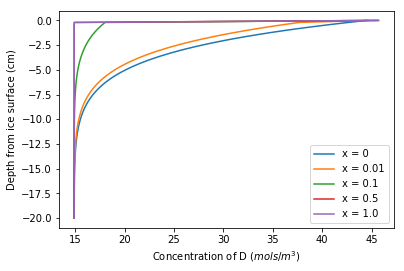

In [197]:
z = np.linspace(0, -20, nz)
plt.plot(c[:, 0], z, label = 'x = 0')
plt.plot(c[:, 10], z, label = 'x = 0.01')
plt.plot(c[:, 100], z, label = 'x = 0.1')
plt.plot(c[:, 500], z, label = 'x = 0.5')
plt.plot(c[:, -1], z, label = 'x = 1.0')
plt.legend()
plt.ylabel('Depth from ice surface (cm)')
plt.xlabel('Concentration of D $(mols/m^3)$')
plt.show()

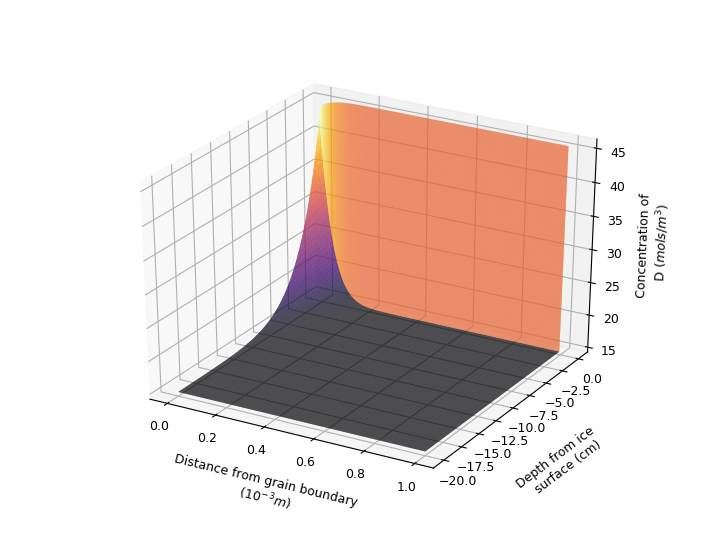

In [73]:
x = np.linspace(0, 1, nx)
z = np.linspace(0, -20, nz)

plt.rcParams.update({'font.size' : 9})
fig = plt.figure(figsize=(9, 7), dpi = 100)
ax = fig.gca(projection='3d')
X, Z = np.meshgrid(x, z)
surf = ax.plot_surface(X, Z, c, rstride=1, cstride=1, cmap=cm.inferno,
    linewidth=0, antialiased=True)
ax.set_zlabel('\n' + '\n' + 'Concentration of \n D ($mols/m^3$)')
ax.set_xlabel('\n' + '\n' + '\n' + 'Distance from grain boundary \n $(10^{-3} m)$')
ax.set_ylabel('\n' + '\n' + '\n' + '\n' + 'Depth from ice \n surface (cm)')
ax.dist = 12


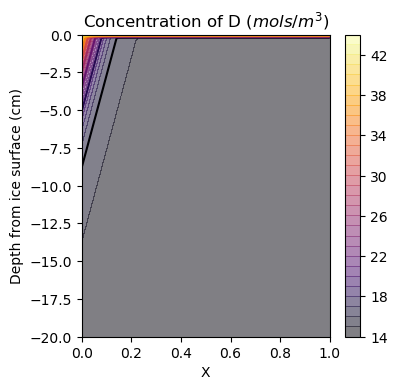

In [66]:
x = np.linspace(0, 1, nx)
z = np.linspace(0, -20, nz)
X, Z = np.meshgrid(x, z)

levels = np.arange(14.0, 45.0, 1.0)

fig = plt.figure(figsize=(4, 4), dpi = 100)
plt.title('Concentration of D ($mols/m^3$)')

plt.contourf(X, Z, c, alpha=0.5, cmap=cm.inferno, levels = levels)
plt.colorbar()
plt.contour(X, Z, c, cmap=cm.inferno)
plt.xlabel('X')
plt.ylabel('Depth from ice surface (cm)');
plt.show()

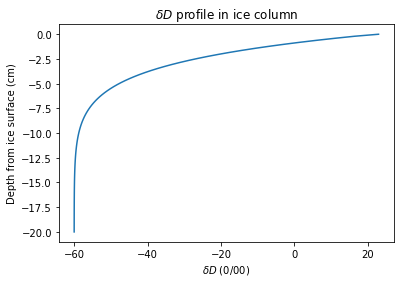

2.55596668104
1.4587023485
-17.6495237714


In [190]:
c_ave = np.zeros(nz)
R_ice =np.zeros(nz)
deltaD_ave = np.zeros(nz)

for k in range(nz):
    c_ave[k] = np.average(c[k, :])

R_ice = (c_ave/c_tot)/(1.0 - (c_ave/c_tot))
deltaD_ave = (R_ice - R_std)/R_std*1000.0

plt.plot(deltaD_ave[1:], np.linspace(0, -20, nz-1))
# plt.plot(c_ave, z)  
# plt.plot(c[:, 1], z)
# plt.plot(c[:, 50], z)
plt.xlabel('$\delta D$ (0/00)')
plt.ylabel('Depth from ice surface (cm)')
plt.title('$\delta D$ profile in ice column')
plt.show()
print np.average(deltaD_ave[1:10])
print deltaD_ave[5]
print deltaD_ave[10]

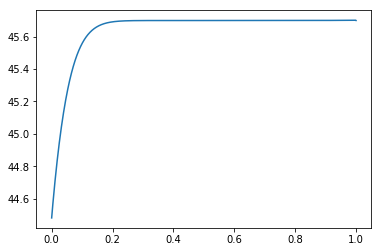

In [164]:
x = np.linspace(0, 1, nx)
plt.plot(x, c[0, :])
plt.show()